# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

##  Final Project: Milestone 2 - Exploratory Data Analysis (EDA) [3 pts]


**Harvard University**<br/>
**Spring 2020**<br/>
**Group Members**: Fernando Medeiros, Mohammed Gufran Pathan, and Prerna Aggarwal<br/>

<hr style="height:2pt">

---

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

# Overview


As part of your final project,  please perform exploratory data analysis (EDA) on the data you have received. In order to simulate the "real world," the details of this are deliberately left open-ended, so your EDA should be what you consider the best for the domain you are working in and the specifics of the data. Please cite any references that you use when learning more about the topic of your project.

 

## Key Questions: 

Given everything you have learned, if you faced this data set in the wild, how would you proceed? 

What are the important measures? 

What are the right questions to ask, and how can the data answer them?

## List of EDAs
1. Volume of cases by year (time trendline) **[done]**
1. Volume of cases by state **[done]**
1. Histogram of number cases authored by each judge **[done]**
1. Length of judgments (pages and word count) **[done]**
1. No. of cases with a minority opinion **[done]**
1. Bar graph of number of cases by court **[done]**
1. ~~Missing values~~ **(misspellings?--Fernando)**
1. ~~Word cloud~~ **(need to install library and may cause dependency issues)**
1. **Visualize embeddings of the text**
1. Size of vocabulary **[done]**
1. ~~No. of distinct words used per judgment (histogram)~~
1. Most common words used **[done]**
1. Most common words used (excluding stop-words) **[done]**
1. **tf-idf of words** (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
1. **Categorical meta-data**
1. **Entity-recognition?** (https://github.com/openlegaldata/legal-ner) (https://spacy.io/usage/linguistic-features#named-entities)
1. **Sentiment of judgment?**


In [250]:
import json
import lzma
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from pandas.io.json import json_normalize

In [226]:
def load_data(states=['new_mexico.xz','arkansas.xz','north_carolina.xz','illinois.xz',]):
#def load_data(states=['new_mexico.xz']):
    base_path = "./data/text"
    data_list = []

    for state in states:
        print(f'Loading data for {state}')
        f = lzma.open(os.path.join(base_path,state),"rb")
        state_data = f.readlines()
        f.close()
        data_json = [json.loads(line) for line in state_data]
        print(f'Flattening data for {state}')
        state_df = json_normalize(data_json)
        state_df['source_state'] = state
        data_list.append(state_df)
    return pd.concat(data_list).reset_index(drop=True)

# To load data for some states use:
# data = load_data(states=['new_mexico.xz','arkansas.xz'])

data = load_data()

Loading data for new_mexico.xz
Flattening data for new_mexico.xz


In [227]:
data.shape

(18338, 36)

In [228]:
data.columns

Index(['id', 'url', 'name', 'name_abbreviation', 'decision_date',
       'docket_number', 'first_page', 'last_page', 'citations', 'frontend_url',
       'preview', 'volume.url', 'volume.barcode', 'volume.volume_number',
       'reporter.url', 'reporter.full_name', 'reporter.id', 'court.url',
       'court.name_abbreviation', 'court.slug', 'court.name', 'court.id',
       'jurisdiction.name', 'jurisdiction.name_long',
       'jurisdiction.whitelisted', 'jurisdiction.url', 'jurisdiction.id',
       'jurisdiction.slug', 'casebody.data.judges', 'casebody.data.attorneys',
       'casebody.data.opinions', 'casebody.data.head_matter',
       'casebody.data.corrections', 'casebody.status', 'casebody.data.parties',
       'source_state'],
      dtype='object')

In [229]:
data.head()

,id,url,name,name_abbreviation,decision_date,docket_number,first_page,last_page,citations,frontend_url,...,jurisdiction.id,jurisdiction.slug,casebody.data.judges,casebody.data.attorneys,casebody.data.opinions,casebody.data.head_matter,casebody.data.corrections,casebody.status,casebody.data.parties,source_state
0,17491,https://api.capapi.org/v1/cases/17491/,"STATE of New Mexico, Plaintiff-Appellee, v. Lo...",State v. Woodruff,1997-11-21,No. 23958,388,399,"[{'type': 'official', 'cite': '124 N.M. 388'},...",https://cite.capapi.org/nm/124/388/,...,52,nm,"[FRANCHINI, C.J., and BACA, SERNA and McKINNON...","[Tangora & Whitley, P.C., Robert E. Tangora, S...","[{'type': 'majority', 'text': 'OPINION MINZNER...",1997-NMSC-061\n951 P.2d 605\nSTATE of New Mexi...,,ok,NaN,new_mexico.xz
1,17129,https://api.capapi.org/v1/cases/17129/,"STATE of New Mexico, ex rel. CHILDREN, YOUTH A...","State ex rel. Children, Youth & Families Depar...",1998-01-29,No. 17771,735,745,"[{'type': 'official', 'cite': '124 N.M. 735'},...",https://cite.capapi.org/nm/124/735/,...,52,nm,"[DONNELLY and BOSSON, JJ., concur.]","[Angela Adams, Chief Children’s Court Attorney...","[{'type': 'majority', 'text': 'OPINION WECHSLE...",1998-NMCA-039\n955 P.2d 204\nSTATE of New Mexi...,,ok,NaN,new_mexico.xz
2,18630,https://api.capapi.org/v1/cases/18630/,"Caye C. BUCKINGHAM, Plaintiff-Appellant, v. Ja...",Buckingham v. Ryan,1997-12-17,"Nos. 17829, 17998",498,504,"[{'type': 'official', 'cite': '124 N.M. 498'},...",https://cite.capapi.org/nm/124/498/,...,52,nm,"[APODACA and ARMIJO, JJ., concur.]","[Maria Garcia Geer, Geer, Wissel & Levy, P.A.,...","[{'type': 'majority', 'text': 'OPINION PICKARD...",1998-NMCA-012\n953 P.2d 33\nCaye C. BUCKINGHAM...,,ok,NaN,new_mexico.xz
3,18319,https://api.capapi.org/v1/cases/18319/,"STATE of New Mexico ex rel. Alan E. WHITEHEAD,...",State ex rel. Whitehead v. Vescovi-Dial,1997-10-23,No. 17715,375,380,"[{'type': 'official', 'cite': '124 N.M. 375'},...",https://cite.capapi.org/nm/124/375/,...,52,nm,"[PICKARD and FLORES, JJ., concur.]","[Tom Udall, Attorney General, Arthur W. Pepin,...","[{'type': 'majority', 'text': 'OPINION BOSSON,...",950 P.2d 818\nSTATE of New Mexico ex rel. Alan...,,ok,NaN,new_mexico.xz
4,17318,https://api.capapi.org/v1/cases/17318/,"STATE of New Mexico, Plaintiff-Appellee, v. Sa...",State v. Rivera,1997-09-09,No. 17750,211,214,"[{'type': 'official', 'cite': '124 N.M. 211'},...",https://cite.capapi.org/nm/124/211/,...,52,nm,"[ALARID and BUSTAMANTE, JJ., concur.]","[Tom Udall, Attorney General, Elizabeth Blaisd...","[{'type': 'majority', 'text': 'OPINION PICKARD...",1997-NMCA-102\n947 P.2d 168\nSTATE of New Mexi...,,ok,NaN,new_mexico.xz


#### No. of cases by year
The number of cases has increased since 1860 reacing a peak in the 1960s then decreasing in the last several decades. 

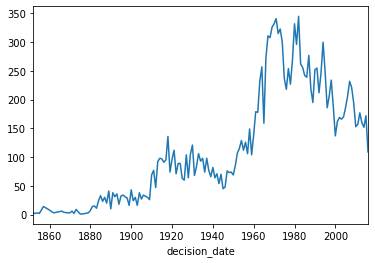

In [230]:
data.groupby([data.decision_date.str[:4].astype(int)])['id'].count().plot()

#### No. of rows in each state file

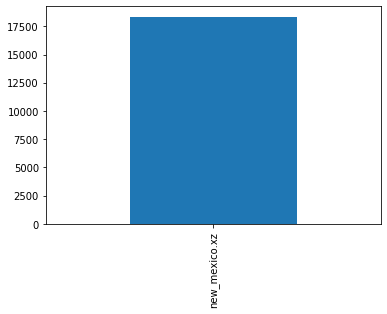

In [101]:
data.source_state.value_counts().plot.bar()

### Viewing sample data

#### Head Matter

In [102]:
n = 1
print(data['casebody.data.head_matter'][n])

1998-NMCA-039
955 P.2d 204
STATE of New Mexico, ex rel. CHILDREN, YOUTH AND FAMILIES DEPARTMENT, Petitioner-Appellee, In the Matter of ESPERANZA M., a child, and concerning Marian M., and Jesus M., Respondents-Appellants.
No. 17771.
Court of Appeals of New Mexico.
Jan. 29, 1998.
Angela Adams, Chief Children’s Court Attorney, Diane Garrity, Roy E. Stephenson, Jean Conner, Children’s Court Attorneys, Santa Fe, for Petitioner-Appellee.
Michael E. Vigil, Marchiondo, Vigil & Associates, P.C., Albuquerque, for Respondents-Appellants.
Jennifer Davis Hall, Albuquerque, Appellate Guardian ad litem.


#### Judges
It appears that opinions with several authors have lower frequencies while opinions with a single author are more frequent.

In [103]:
data['casebody.data.judges']

0        [FRANCHINI, C.J., and BACA, SERNA and McKINNON...
1                      [DONNELLY and BOSSON, JJ., concur.]
2                       [APODACA and ARMIJO, JJ., concur.]
3                       [PICKARD and FLORES, JJ., concur.]
4                    [ALARID and BUSTAMANTE, JJ., concur.]
                               ...                        
18333                  [DONNELLY and FLORES, JJ., concur.]
18334    [Daniel Viramontes, District Judge, RODERICK T...
18335                     [ALARID and HARTZ, JJ., concur.]
18336                  [DONNELLY and BOSSON, JJ., concur.]
18337    [BRICE, C. J., and LUJAN, SADLER and COMPTON, ...
Name: casebody.data.judges, Length: 18338, dtype: object

In [164]:
for i in range(4):
    data[f'casebody.data.opinions.author{i}'] = data['casebody.data.opinions'].map(lambda x: x[i]['author'] if len(x)>=i+1 else None)

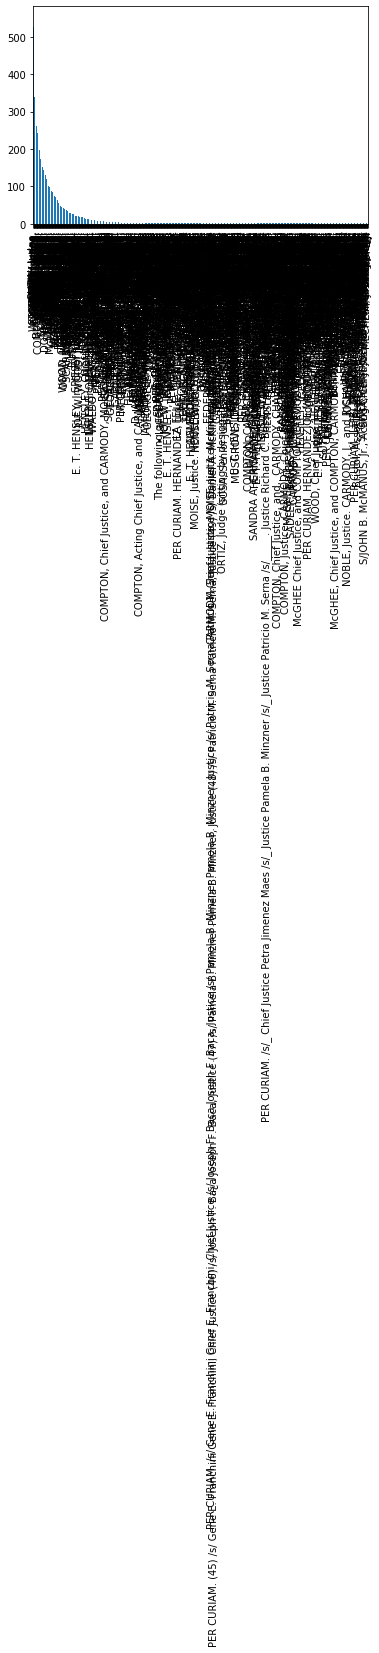

In [214]:
data['casebody.data.opinions.author0'].value_counts().plot.bar()

#### Courts

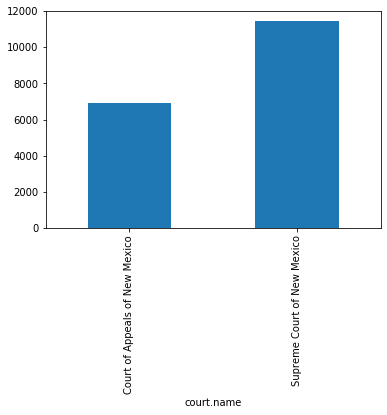

In [206]:
data.groupby([data['court.name']])['id'].count().plot.bar()

#### Attorneys

In [104]:
data['casebody.data.attorneys']

0        [Tangora & Whitley, P.C., Robert E. Tangora, S...
1        [Angela Adams, Chief Children’s Court Attorney...
2        [Maria Garcia Geer, Geer, Wissel & Levy, P.A.,...
3        [Tom Udall, Attorney General, Arthur W. Pepin,...
4        [Tom Udall, Attorney General, Elizabeth Blaisd...
                               ...                        
18333    [Tom Udall, Attorney General, Ralph E. Trujill...
18334    [Hector H. Balderas, Attorney General Santa Fe...
18335    [Peter V. Culbert, Jones, Snead, Wertheim, Wen...
18336    [Patricia A. Madrid, Attorney General, James O...
18337    [Glen G. Hilford, Hot Springs, for appellants....
Name: casebody.data.attorneys, Length: 18338, dtype: object

#### Corrections

In [105]:
data['casebody.data.corrections']

0         
1         
2         
3         
4         
        ..
18333     
18334     
18335     
18336     
18337     
Name: casebody.data.corrections, Length: 18338, dtype: object

#### Status

In [106]:
data['casebody.status'].value_counts()

ok    18338
Name: casebody.status, dtype: int64

There is only one value for 'status' which is 'ok'. 

#### Opinions

In [107]:
json_normalize(data['casebody.data.opinions'][9])

,type,text,author
0,majority,"OPINION\nFRANCHINI, Chief Justice.\n1 Timothy ...","FRANCHINI, Chief Justice."
1,concurrence,"MINZNER, Justice\n(specially concurring).\n128...","MINZNER, Justice"
2,dissent,"BACA, Justice\n(Dissenting).\nWhile I am mindf...","BACA, Justice"


The 'Casebody.data.opinions' field is a nested json with type, text and author fields for each opinion. A case can have multiple opinions. As can be seen above, there are three opinions - a majority opinion, a concurrence opinion and a dissenting opinion.

#### How many opinions in a case?

We see that a case can have upto 8 different opinions. Most cases have have 1 opinions and some have two. Very few have more than 2 opinions.

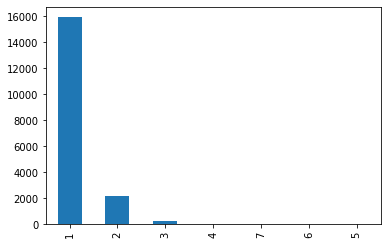

In [108]:
data['casebody.data.opinions'].map(lambda x:len(x)).value_counts().plot.bar()

In [109]:
data['casebody.data.opinions'].map(lambda x:len(x)).value_counts()

1    15919
2     2156
3      228
4       32
7        1
6        1
5        1
Name: casebody.data.opinions, dtype: int64

##### Flattening opinions column

In [110]:
for i in range(4):
    data[f'casebody.data.opinions.type{i}'] = data['casebody.data.opinions'].map(lambda x: x[i]['type'] if len(x)>=i+1 else None)
    data[f'casebody.data.opinions.text{i}'] = data['casebody.data.opinions'].map(lambda x: x[i]['text'] if len(x)>=i+1 else None)

In [111]:
data['casebody.data.opinions.text0']

0        OPINION\nMINZNER, Justice.\n(1)Defendant Lonni...
1        OPINION\nWECHSLER, Judge.\n1. As a result of a...
2        OPINION\nPICKARD, Judge.\n¶ 1 This case requir...
3        OPINION\nBOSSON, Judge.\n1. Article II, Sectio...
4        OPINION\nPICKARD, Judge.\n1. Defendant appeals...
                               ...                        
18333    OPINION\nHARTZ, Chief Judge.\n(1) Defendant pl...
18334    OPINION\nKENNEDY, Judge.\nI. INTRODUCTION\n{1}...
18335    OPINION\nAPODACA, Chief Judge.\n1.Worker appea...
18336    OPINION\nBUSTAMANTE, Judge.\n{1} These consoli...
18337    McGHEE, Justice.\nThe appellants owned all of ...
Name: casebody.data.opinions.text0, Length: 18338, dtype: object

#### Opinion text

Below is a text of one of the opionns

In [112]:
data['casebody.data.opinions.text0'][0]

'OPINION\nMINZNER, Justice.\n(1)Defendant Lonnie Woodruff appeals from a judgment and sentence entered after his conviction by a jury of driving while under the influence of. intoxicating liquor (DWI) contrary to NMSA 1978, § 66-8-102 (1994, prior to 1997 amendment). On appeal, he contends he was denied due process of law under the New Mexico Constitution when the district court enhanced his sentence from a first offense to a second offense as a result of a prior conviction for which he was not represented by counsel. We affirm.\nI.\n(2) Following Woodruffs conviction, the State filed a supplemental criminal information. In that supplemental information, the State alleged that Woodruff had two prior convictions for DWI. Defendant admitted that he was the person named in the two counts of the supplemental information. However, he challenged one of the convictions on the basis that the State failed to show he had waived his right to counsel and that he had not been represented by counsel

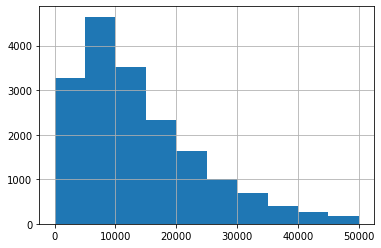

In [113]:
# the number of characters in each opinion
data['casebody.data.opinions.text0'].str.len().hist(range=(0,50000));

In [114]:
max(data['casebody.data.opinions.text0'].str.len())

390445

Most opinions have upto 20,000 characters. The longest opinion has 390,000 characters

In [208]:
# Cell takes too long to run and fails. Consider tokenizing with nltk or on a sample
# the number of words appearing in each opinion
data['casebody.data.opinions.word_count'] = data['casebody.data.opinions.text0'].apply(lambda x: len(str(x).split()))

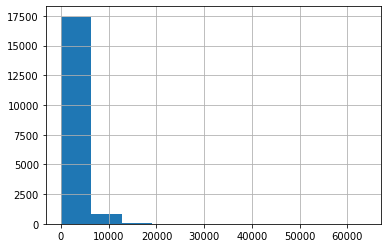

In [210]:
data['casebody.data.opinions.word_count'].hist()

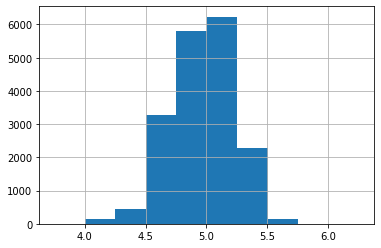

In [117]:
# the average word length in each opinion
data['casebody.data.opinions.text0'].str.split().\
   apply(lambda x : [len(i) for i in x]).\
   map(lambda x: np.mean(x)).hist()

#### Types of opinions

In [118]:
data['casebody.data.opinions.type0'].value_counts()

majority       18324
rehearing         11
concurrence        3
Name: casebody.data.opinions.type0, dtype: int64

In [119]:
data['casebody.data.opinions.type1'].value_counts()

dissent                                      1103
concurrence                                   754
rehearing                                     294
concurring-in-part-and-dissenting-in-part     261
on-the-merits                                   4
majority                                        2
on-motion-to-strike-cost-bill                   1
Name: casebody.data.opinions.type1, dtype: int64

In [120]:
data['casebody.data.opinions.type2'].value_counts()

dissent                                      138
concurrence                                   60
rehearing                                     33
concurring-in-part-and-dissenting-in-part     32
Name: casebody.data.opinions.type2, dtype: int64

In [121]:
opinions = data['casebody.data.opinions.text0'].str.split().values.tolist()

In [207]:
words = []
for word in opinions:
    words += word

In [123]:
# the number of times a word appears in all opinions
pd.DataFrame(words).stack().value_counts()

the            3303246
of             1722385
to             1297921
and             964640
that            818157
                ...   
609-610,             1
eamings,             1
(seasonal            1
682.2,               1
ex-husband;          1
Length: 632132, dtype: int64

In [222]:
len(Counter(words).keys())

632132

The length of the vocabulary for all opinions is ###,###,###

<function matplotlib.pyplot.show(*args, **kw)>

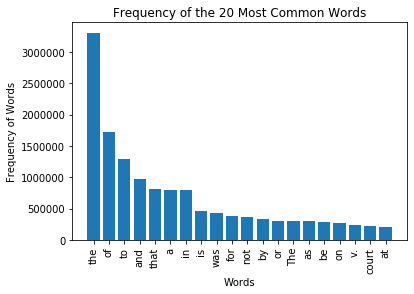

In [236]:
common_words = FreqDist(words).most_common(20)
x, y = zip(*common_words)
plt.figure()
plt.bar(x, y)
plt.title('Frequency of the 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=90)
plt.show

In [294]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

for i, w in enumerate(words):
    if w=='The':
        words[i] = 'the'
    if w=='In':
        words[i] = 'in'

word_count = Counter(words)
most_words = word_count.most_common()

In [305]:
x, y = [], []
for word, count in most_words:
    if (word not in stop_words):
        x.append(word)
        y.append(count)

Text(0.5, 1.0, 'Frequency of the 20 Most Non-stop Words')

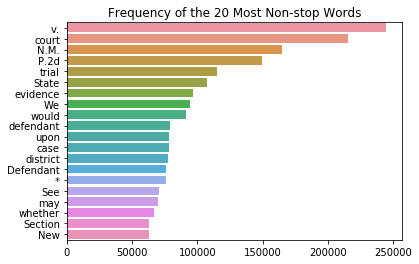

In [306]:
sns.barplot(x=y[0:20], y=x[0:20]).set_title('Frequency of the 20 Most Non-stop Words')

# Key Questions: 

### Given everything you have learned, if you faced this data set in the wild, how would you proceed? 

We'd do the following for **acquiring training data**:

1) Search for labelled data. Currently we do not have summaries available. It would be good to have summaries of some of the cases which we can use for training.

2) If aquiring summaries is not possible, we can try identifying key legal terms in the text using Legal NLP tools such as LexNLP (https://github.com/LexPredict/lexpredict-lexnlp) and Legal NER (https://github.com/openlegaldata/legal-ner)

3) It would be nice to manually label a few summaries. We do not have a law background, so our labelling might not be the best. However, if we have the funds, we could recruit legal aides to do the summarization for a few cases.

#### Methodology:

There are two ways to generate summaries 

1) Extractive: No new sentences are generated. Sentences from the main text are selected to be used in the summary. This becomes a binary classification problem where for a given sentence, we want to predict whether it's suitable to be used in the summary or not.

2) Abstractive: New sentences are generated. If training data with abstract summaries are available, a seq2seq kind of a model could be used to learn generation of summaries. The input would be the main text and the y-labels would be the summaries.

Sources:

https://www.sciencedirect.com/science/article/pii/S1319157819301259

https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

### What are the important measures? 

A good summary should have the following characteristics:

1) Sentences should be intelligible

2) All important ideas should be encapsulated in the summary

3) Should be substantially shorter than the main text

As of now, we're not very sure how these metrics can be quantified.

### What are the right questions to ask, and how can the data answer them?

A legal practitioner maybe interested in the ability to do the following:

1) Get relevant judgments given a certain circumstance (e.g. racial profiling by the police)

2) Find judgments similar to a given judgment

3) Get answer to a particular question (e.g. Is there a precedent to curb free speech in the interest of public good?)

Generating good summaries and building a query / search functionality on top of it may help answer these questions.